In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from six.moves import urllib
import seaborn as sns
import time

from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from nltk.tokenize import RegexpTokenizer  
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.pipeline import make_pipeline

import pickle# use to dump model 

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf
print(tf.__version__)

2.5.0


In [2]:
dftrain = pd.read_csv('E:/Codes/Python/ML Phising Detector/Datasets/phishing_site_urls.csv')
dfeval = pd.read_csv('E:/Codes/Python/ML Phising Detector/Datasets/test.csv')

In [3]:
label_counts = pd.DataFrame(dftrain.Label.value_counts())
print(label_counts)

    Label
1  486263
0  392865


c:\users\steven\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='Label'>

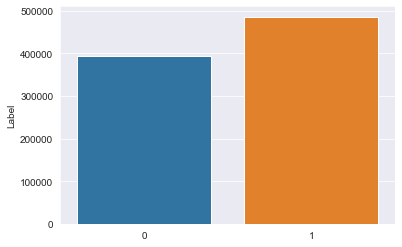

In [4]:
sns.set_style('darkgrid')
sns.barplot(label_counts.index,label_counts.Label)

In [5]:
def treat_data(datain):
    tokenizer = RegexpTokenizer(r'[A-Za-z]+')
    tokenizer.tokenize(datain.URL[0])
    print('Getting words tokenized ...')
    t0= time.perf_counter()
    datain['text_tokenized'] = datain.URL.map(lambda t: tokenizer.tokenize(t))
    t1 = time.perf_counter() - t0
    print('Time taken',t1 ,'sec')

    stemmer = SnowballStemmer("english")
    print('Getting words stemmed ...')
    t0= time.perf_counter()
    datain['text_stemmed'] = datain['text_tokenized'].map(lambda l: [stemmer.stem(word) for word in l])
    t1= time.perf_counter() - t0
    print('Time taken',t1 ,'sec')

    print('Getting joiningwords ...')
    t0= time.perf_counter()
    datain['text_sent'] = datain['text_stemmed'].map(lambda l: ' '.join(l))
    t1= time.perf_counter() - t0
    print('Time taken',t1 ,'sec')

    dataout = datain
    return dataout

In [6]:
dftrain = treat_data(dftrain)
dftrain.shape

Getting words tokenized ...
Time taken 2.7008202 sec
Getting words stemmed ...
Time taken 37.37827970000001 sec
Getting joiningwords ...
Time taken 0.24157269999999897 sec


(879128, 5)

In [7]:
dftrain.sample(10)

,URL,Label,text_tokenized,text_stemmed,text_sent
12328,amazon.com/Connee-Boswell/e/B000APZ6FY,0,"[amazon, com, Connee, Boswell, e, B, APZ, FY]","[amazon, com, conne, boswel, e, b, apz, fy]",amazon com conne boswel e b apz fy
707864,minatajhiz.com,1,"[minatajhiz, com]","[minatajhiz, com]",minatajhiz com
298766,paypal.co.uk.rh2b.icu,1,"[paypal, co, uk, rh, b, icu]","[paypal, co, uk, rh, b, icu]",paypal co uk rh b icu
179477,theblurb.ca/professional_services/Michel_Pilon...,0,"[theblurb, ca, professional, services, Michel,...","[theblurb, ca, profession, servic, michel, pil...",theblurb ca profession servic michel pilon ser...
620147,streetsource.com/forum/110123_0_Buildups-BODY-...,0,"[streetsource, com, forum, Buildups, BODY, DRO...","[streetsourc, com, forum, buildup, bodi, drop,...",streetsourc com forum buildup bodi drop f on s...
167603,dibbern.com/nursing-homes/washington/washingto...,0,"[dibbern, com, nursing, homes, washington, was...","[dibbern, com, nurs, home, washington, washing...",dibbern com nurs home washington washington nu...
638480,habbototemraro.rel7.com/,1,"[habbototemraro, rel, com]","[habbototemraro, rel, com]",habbototemraro rel com
851852,servinghistory.com/topics/Ford_385_engine,0,"[servinghistory, com, topics, Ford, engine]","[servinghistori, com, topic, ford, engin]",servinghistori com topic ford engin
425140,katiewheelerlibrary.wordpress.com/irvine-famil...,0,"[katiewheelerlibrary, wordpress, com, irvine, ...","[katiewheelerlibrari, wordpress, com, irvin, f...",katiewheelerlibrari wordpress com irvin famili...
23164,newswire.ca/en/story/689741/crtc-approves-shaw...,0,"[newswire, ca, en, story, crtc, approves, shaw...","[newswir, ca, en, stori, crtc, approv, shaw, s...",newswir ca en stori crtc approv shaw s purchas...


In [8]:
dfeval = treat_data(dfeval)
dfeval.shape

Getting words tokenized ...
Time taken 0.0007528000000007751 sec
Getting words stemmed ...
Time taken 0.006744700000005821 sec
Getting joiningwords ...
Time taken 0.0006334000000052242 sec


(133, 5)

In [9]:
dfeval.sample(10)

,URL,Label,text_tokenized,text_stemmed,text_sent
38,hoosierhillshoops.com/2011/08/05/new-albanys-w...,0,"[hoosierhillshoops, com, new, albanys, whitehe...","[hoosierhillshoop, com, new, albani, whitehead...",hoosierhillshoop com new albani whitehead head...
22,lovejessy.com/whatSapp/,1,"[lovejessy, com, whatSapp]","[lovejessi, com, whatsapp]",lovejessi com whatsapp
85,samfordsports.com/sports/m-baskbl/spec-rel/sam...,0,"[samfordsports, com, sports, m, baskbl, spec, ...","[samfordsport, com, sport, m, baskbl, spec, re...",samfordsport com sport m baskbl spec rel samf ...
103,city-data.com/city/Waverly-Missouri.html,0,"[city, data, com, city, Waverly, Missouri, html]","[citi, data, com, citi, waver, missouri, html]",citi data com citi waver missouri html
111,revolute-efficienci.000webhostapp.com,1,"[revolute, efficienci, webhostapp, com]","[revolut, effici, webhostapp, com]",revolut effici webhostapp com
17,m-facebook.co,1,"[m, facebook, co]","[m, facebook, co]",m facebook co
11,exploretalent.com/taylormatheny,0,"[exploretalent, com, taylormatheny]","[exploretal, com, taylormatheni]",exploretal com taylormatheni
68,emusic.com/album/Harmonica-Shah-If-All-You-Hav...,0,"[emusic, com, album, Harmonica, Shah, If, All,...","[emus, com, album, harmonica, shah, if, all, y...",emus com album harmonica shah if all you have ...
2,hampshirepolicechoir.org.uk/,0,"[hampshirepolicechoir, org, uk]","[hampshirepolicechoir, org, uk]",hampshirepolicechoir org uk
36,thamaritan.com,1,"[thamaritan, com]","[thamaritan, com]",thamaritan com


In [10]:
cv = CountVectorizer()
feature = cv.fit_transform(dftrain.text_sent)
feature[:5].toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [11]:
trainX, testX, trainY, testY = train_test_split(feature, dftrain.Label)

In [ ]:
lr = LogisticRegression(max_iter=5000)
lr.fit(trainX,trainY)

In [ ]:
lr.score(testX,testY)

In [ ]:
Scores_ml = {}
Scores_ml['Logistic Regression'] = np.round(lr.score(testX,testY),2)

In [ ]:
print('Training Accuracy :',lr.score(trainX,trainY))
print('Testing Accuracy :',lr.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(lr.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(lr.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [ ]:
pipeline_ls = make_pipeline(CountVectorizer(tokenizer = RegexpTokenizer(r'[A-Za-z]+').tokenize,stop_words='english'), LogisticRegression(max_iter=5000))

In [ ]:
trainX, testX, trainY, testY = train_test_split(dftrain.URL, dftrain.Label)

In [ ]:
pipeline_ls.fit(trainX,trainY)

In [ ]:
pipeline_ls.score(testX,testY)

In [ ]:
pickle.dump(pipeline_ls,open('phishing_detector.pkl','wb'))

In [ ]:
loaded_model = pickle.load(open('E:/Codes/Python/ML Phising Detector/phishing_detector.pkl', 'rb'))

In [ ]:
test = ['https://github.com/taruntiwarihp/Projects_DS/blob/master/Phishing Site URLs Prediction/prediction_app.py']
probability = loaded_model.predict_proba(test)
result = loaded_model.predict(test)
print(probability, result)

In [ ]:
print(probability[0,1])